# Introduction 😄
Intuitions and evidences suggest that local resource concentrations and species abundances are with high probability irrelavent to stability. A generalized criterion based on Tilman's graphic method establishing such a property is proposed and tested. Results on $GC^\top$ are also shown.

# Theory

## Preliminaries
The species and resources dynamics is given by 
$$
\frac{\mathrm{d} S_i}{\mathrm{d} t} = S_i \Big(\sum_{\alpha}G_{i\alpha}R_{\alpha} - \delta_i \Big),\\
\frac{\mathrm{d} R_{\alpha}}{\mathrm{d} t} = l_{\alpha} - R_{\alpha}\sum_{i}C_{i\alpha}S_i.
$$
Local Jacobian at fixed point is 
$$
   J^* = \left(\begin{array}{c|c}
       O  & D(S^*)G\\[1.0ex]
     \hline\\[-1.0ex]
     -D(R^*)C^\top   & - D(C^\top S^*)
    \end{array}
    \right).
$$

## Normailzed growth-consumption analysis
The $i$ th row of a matrix $A$ is denoted by $A_i$ which is a vector. Define matrix $V$ as 
$$
V = C D(R^*),
$$
$V_i$ are called the impact vectors in Tilman's graphic method. Stability is determined by whether the imapct vectors flip. The reference of "flip" is given by $G$, whose rows $G_i$ are normal vectors of ZNGIs. Since $R^*$ are all positive, they do not change whether $C_i$ flip. So, we can only focus on $G$ and $C$. 

Also note that only the directions of vecotors matters, we normalize the vectors to the simplex. For any matrix $A$, we use $\tilde{A}$ to denote the normalized matrix whose rows are all on the simplex, i.e., $\tilde{A}_{i\alpha} = A_{i\alpha}/\sum_{\beta}A_{i\beta}$. For any two matrices $A$ and $B$, we can define 
$$
I(A,B) = \frac{J(A,B)}{H(A,A)},
$$
where $J(A,B)$ calculates mean $\| \tilde{A}_i - \tilde{B}_i \|$, and $H(A,A)$ defines mean minimum distances between $\tilde{A}_i$ and $\tilde{A}_j$ for $i\neq j$.

We need to use $G$ to define the reference center. To find the centers, we use optimization. Therefore, we can define encroachment,
$$
E(G,C) = \min_D I(G,CD),
$$
where $D$ is diagonal and positive definite. 

Intuitively, as long as we can find a $D$ such that $CD = G$, the system can be seen to be as stable as the case $C=G$. We define a stability equivalence class: the systems where there exists a diagonal and positive definite, s.t. $CD = G$. The definition $E(G,C)$ makes sure that for systems in this equivalence class, $E = 0$. In plain words, we define $C=G$ and similar systems as the most stable cases.

## On $GC^\top$
The unstable mode fractions of $J^*$ is almost the same as that of $GC^\top$! Very interesting.

# Experiments
Real Jacobian (whose unstable mode fraction should be the evidence), encroachment (NGCA), and $GC^\top$ (also focus on the unstable mode fraction).

## Sample all the things

Most importantly, how should we get $G$ and $C$. First sample two matrices from uniform distribution, then use [Cholesky decomposition](https://math.stackexchange.com/questions/163470/generating-correlated-random-numbers-why-does-cholesky-decomposition-work#) to correlate them, then choose one to be $C$ and the other to be $G$, at last use some random positive diagonal matrix to move $C$ away.

In [19]:
import torch
import math

Ns = 40 # # of species
Nr = 32 # # of resources

rho = .8 # correlation

sample = torch.rand(Ns,2,Nr)
L = torch.tensor([[1, 0],
                 [rho, math.sqrt(1-rho**2)]]) # Cholesky decomposition

sample = torch.matmul(L,sample)

G = sample[0:Ns,0]
C = sample[0:Ns,1] # C has not been pushed away

C = C @ torch.diag(0.01+ 0.99*torch.rand(Nr))

### Do analysis

Get the real Jacobian and fraction of unstable modes

In [20]:
Sstar = 0.01 + 0.99*torch.rand(Ns)
Rstar = 0.01 + 0.99*torch.rand(Nr)

Jstar = torch.zeros(Ns+Nr,Ns+Nr)
Jstar[0:Ns,Ns:Ns+Nr] = torch.diag(Sstar) @ G
Jstar[Ns:Ns+Nr,0:Ns] = - torch.diag(Rstar) @ C.transpose(0,1)
Jstar[Ns:Ns+Nr,Ns:Ns+Nr] = - torch.diag(C.transpose(0,1) @ Sstar)

E_J = torch.linalg.eigvals(Jstar).real
FU_J = len(E_J[E_J >= 1.0e-5])/Ns # Fraction of Unstable modes of the real Jacobian

Also get $GC^\top$ and corresponding fraction of unstable modes

In [21]:
E_GC = torch.linalg.eigvals(- G @ C.transpose(0,1)).real
FU_GC = len(E_GC[E_GC >= 1.0e-5])/Ns
print('Unstable mode fraction for J is',FU_J,
      'and that for GC is',FU_GC)

Unstable mode fraction for J is 0.025 and that for GC is 0.025


Now, let's use optimization to find $D$ and the encroachment.

So $CD$ will be a linear layer, and $I(G,CD)$ is the loss function.

In [22]:
import torch.nn as nn

class rescale(nn.Module):
    def __init__(self,Nr):
        super(rescale, self).__init__()
        self.D = nn.Parameter(torch.ones(Nr)) # not sure if devided by sqrt(Nr)

    def forward(self, C):
        output = C @ torch.diag(self.D)
        return output


Prepare the loss function in the following block. First normalize both $G$ and $CD$ to the simplex, then calculate $G-G$ distances and $C-G$ distances.

In [23]:
def NormalG(G):
    G = torch.diag((torch.sum(G, 1))**(-1)) @ G
    return G

def H(G,Ns):
    # normaized to the simplex
    G = torch.diag((torch.sum(G, 1))**(-1)) @ G

    # G-G distances
    distances = torch.zeros(Ns,Ns)
    for i in range(Ns-1):
        for j in range(i+1, Ns):
            distances[i,j] = torch.linalg.norm(G[i] - G[j])
    distances = distances + distances.transpose(0,1) + 2*torch.diag(torch.ones(Ns))
    minDis = torch.min(distances, 1).values
    H = torch.mean(minDis)
    return H


def Loss(NG,CD,H):
    # normaized to the simplex
    CD = torch.diag((torch.sum(CD, 1))**(-1)) @ CD

    # G-C distances
    I = torch.mean(torch.linalg.norm(NG - CD, dim=1))

    # G-G distances given by H
    # by definition
    E = I/H
    return E

now we can train and find $E(G,C)$

In [26]:
from torch import optim
# the following are fixed
HG = H(G,Ns) 
NorG = NormalG(G)
lr = 0.2
epochs = 1000
losses = torch.zeros(epochs)

layer = rescale(Nr)
opt = optim.SGD(layer.parameters(), lr=lr, momentum=0.9)

E = 0 # initailize E(G,C)
# training process
for epoch in range(epochs):
    CD = layer(C)
    loss = Loss(NorG,CD,HG)

    loss.backward()
    opt.step()
    opt.zero_grad()

    losses[epoch] = loss.item()
    if epoch >= epochs - 100:
        E = (E*(epoch - epochs + 100) + loss.item())/(epoch - epochs + 101)

print('E(G,C) is %.4f' % E)
list(layer.parameters()) # check if all values are positive!

E(G,C) is 0.5587


[Parameter containing:
 tensor([0.2134, 0.7373, 0.2001, 0.2707, 0.2077, 0.1766, 0.2083, 0.1821, 0.5429,
         0.4182, 1.2139, 0.4234, 0.2330, 4.1236, 0.4662, 0.2324, 0.2204, 0.7158,
         0.2289, 0.9847, 0.3976, 1.0689, 0.9924, 0.1968, 0.3402, 0.2390, 0.1694,
         4.9116, 2.3962, 0.5786, 0.3049, 0.2679], requires_grad=True)]

Text(0, 0.5, 'Loss, $I(G,CD)$')

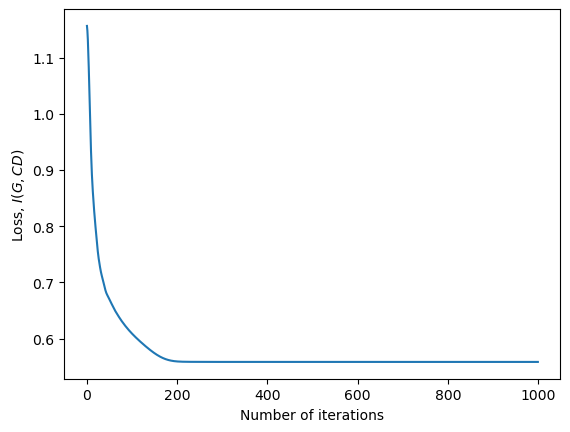

In [27]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(losses)
plt.xlabel('Number of iterations')
plt.ylabel('Loss, $I(G,CD)$')

## Scale it! 🤗

Now, we need to sample from different $N_S/N_R$ and correlation $\rho$ to try to draw heat maps. In this Jupyter notebook, just try to provide the full code, and test it with relatively small range. Really scale it up in another code and maybe run it on SuperCloud.

In [28]:
Nr = 32
Ns_span = range(4,48 + 1,4)

num_rho = 10 # must be even
rho_span = torch.zeros(num_rho)
rho_span[:int(num_rho/2)] = torch.linspace(0, .85, steps=int(num_rho/2))
rho_span[int(num_rho/2):] = torch.linspace(.87, 1, steps=int(num_rho/2))

# initialization of outputs
# Outputs[0]: FU_J; Outputs[1]: FU_GC; Outputs[2]: E;
Outputs = torch.zeros(3,len(Ns_span),len(rho_span))

for i in range(len(Ns_span)):
    Ns = Ns_span[i]
    for j in range(len(rho_span)):
        rho = rho_span[j]

        # sampling 
        sample = torch.rand(Ns,2,Nr)
        L = torch.tensor([[1, 0],
                        [rho, math.sqrt(1-rho**2)]]) # Cholesky decomposition

        sample = torch.matmul(L,sample)

        G = sample[0:Ns,0]
        C = sample[0:Ns,1] # C has not been pushed away

        C = C @ torch.diag(0.01+ 0.99*torch.rand(Nr))
        Sstar = 0.01 + 0.99*torch.rand(Ns)
        Rstar = 0.01 + 0.99*torch.rand(Nr)

        Jstar = torch.zeros(Ns+Nr,Ns+Nr)
        Jstar[0:Ns,Ns:Ns+Nr] = torch.diag(Sstar) @ G
        Jstar[Ns:Ns+Nr,0:Ns] = - torch.diag(Rstar) @ C.transpose(0,1)
        Jstar[Ns:Ns+Nr,Ns:Ns+Nr] = - torch.diag(C.transpose(0,1) @ Sstar)

        E_J = torch.linalg.eigvals(Jstar).real
        Outputs[0,i,j] = len(E_J[E_J >= 1.0e-3])/Ns # Fraction of Unstable modes of the real Jacobian
        E_GC = torch.linalg.eigvals(- G @ C.transpose(0,1)).real
        Outputs[1,i,j] = len(E_GC[E_GC >= 1.0e-3])/Ns

        HG = H(G,Ns) 
        NorG = NormalG(G)
        lr = 0.2
        epochs = 1000

        layer = rescale(Nr) # get new model!
        opt = optim.SGD(layer.parameters(), lr=lr, momentum=0.9)

        E = 0 # initailize E(G,C)
        # training process
        for epoch in range(epochs):
            CD = layer(C)
            loss = Loss(NorG,CD,HG)

            loss.backward()
            opt.step()
            opt.zero_grad()

            if epoch >= epochs - 100:
                E = (E*(epoch - epochs + 100) + loss.item())/(epoch - epochs + 101)
        
        Outputs[2,i,j] = E


Plots

Text(0, 0.5, 'Fraction of unstable modes for $GC^T$')

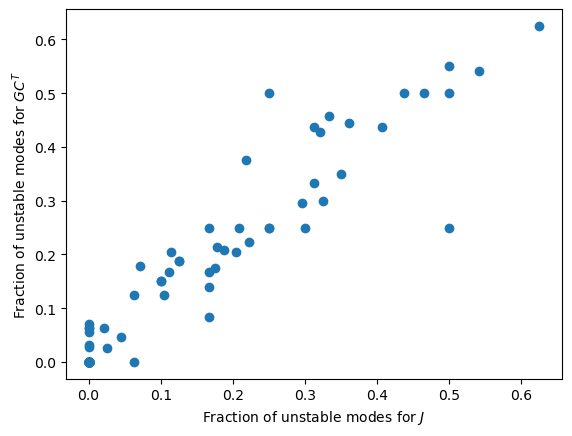

In [29]:
plt.figure()
plt.scatter(Outputs[0],Outputs[1])
plt.xlabel('Fraction of unstable modes for $J$')
plt.ylabel('Fraction of unstable modes for $GC^T$')

Text(0, 0.5, 'Encroachment, $E(G,C)$')

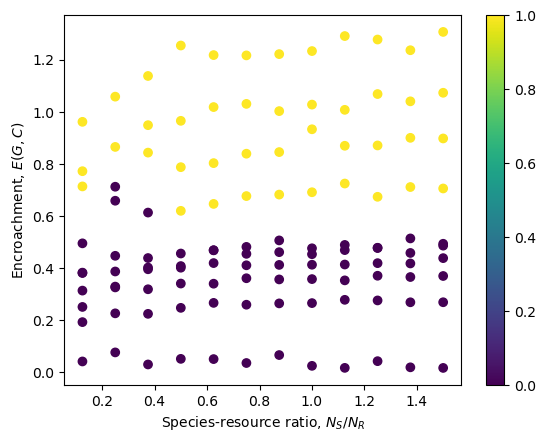

In [30]:
NsNr = (torch.tensor(Ns_span).view(1,len(Ns_span)).transpose(0,1) * torch.ones(1,len(rho_span)))/Nr
unstable = Outputs[0] > 0
plt.figure()
plt.scatter(NsNr,Outputs[2],c=unstable) # try to plot something like the fraction of unstable states (inside one pixel)
plt.colorbar()

plt.xlabel('Species-resource ratio, $N_S/N_R$')
plt.ylabel('Encroachment, $E(G,C)$')

The color above only has two possibilities: yellow (the community is unstable) and purple (the community is stable). The results are exciting! 🥳

Try to plot heat map

In [31]:
# let's draw E from 0 to 1.4 with 0.1 as a step
heat_value = torch.zeros(14,12)
num_point = torch.zeros(14,12)
for i in range(unstable.size(dim=0)):
    for j in range(unstable.size(dim=1)):
       ii = 13 - int(Outputs[2][i,j] * 10)
       jj = int(NsNr[i,j] * Nr / 4) - 1
       heat_value[ii,jj] = (num_point[ii,jj]*heat_value[ii,jj] + unstable[i,j])/(num_point[ii,jj] + 1)
       num_point[ii,jj] = num_point[ii,jj] + 1

#heat_value[:8,:] = torch.ones(heat_value[:8,:].size())

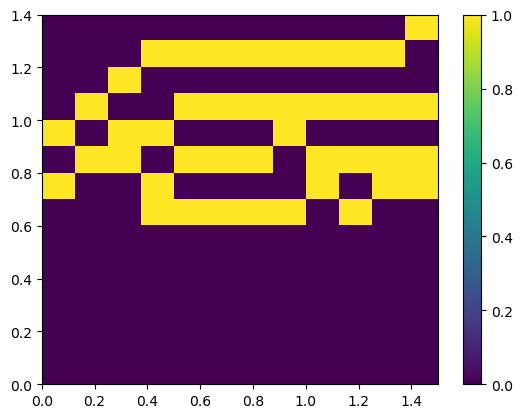

In [32]:
extent = .0, 1.5, .0, 1.4
plt.figure()
plt.imshow(heat_value, extent = extent)
plt.colorbar()